In [1]:
import re
import glob
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import skew 
from wordcloud import WordCloud, STOPWORDS 
from graphviz import Digraph
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from heapq import nlargest
from statsmodels.distributions.empirical_distribution import ECDF
import os

In [2]:
sns.set_style("whitegrid")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.style.use('ggplot')
plt.rc('font', size=8)
colors_vec = ["#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6", "#fabebe", "#008080"]
pallete = sns.color_palette(colors_vec)

In [3]:
def plot_dist_sentiment(files, graphs, filename):
    frac_sentiments = np.empty((0,1))
    for each in files:
        arq = each.split("_")
        if len(arq) == 2:
            original = each
            arq = each.split(".")
            quotes = glob.glob(arq[0] + "_*.json")
            all_sentiments, dist_sentiment, positives, negatives = get_dist_sentiment(quotes, graphs)
            classif = classify_dist_quotes(dist_sentiment, original, graphs)
            frac_sentiments = np.append(frac_sentiments, classif)
    ecdf_sentiment = ECDF(frac_sentiments)
    _= plt.figure(figsize = (20,10))
    _= plt.plot(ecdf_sentiment.x, ecdf_sentiment.y)
    _= plt.xlabel("Fração de árvores com sentimento maior que 0")
    _= plt.ylabel("Probabilidade cumulativa")
    _= plt.savefig(filename, quality = 95, orientation='portrait')

In [4]:
def get_graphs(files):
    graphs = dict()
    for filename in files:
        DG = nx.DiGraph()
        with open(filename, 'r', encoding="utf8") as f: 
            data = json.load(f)
            for tweet in data:
                DG.add_node(tweet)
                if(data[tweet]['replie_to'] is not None):
                    DG.add_node(data[tweet]['replie_to'])
                    DG.add_edge(tweet,data[tweet]['replie_to'])
                for attr in data[tweet]:
                    DG.nodes[tweet][attr] = data[tweet][attr]
        graphs[filename] = DG
    opp_adjacency = dict()
    for each in graphs:
        list_adj = dict()
        for item in graphs[each]:
            try:
                list_adj[item]
            except:
                list_adj[item] = list()
            if (graphs[each].nodes[item]['replie_to'] is not None):
                try:
                    list_adj[graphs[each].nodes[item]['replie_to']].append(item)
                except:
                    list_adj[graphs[each].nodes[item]['replie_to']] = list()
                    list_adj[graphs[each].nodes[item]['replie_to']].append(item)
        opp_adjacency[each] = list_adj 
    return graphs, opp_adjacency

In [5]:
def size(graphs):
    size = 0
    trees = 0
    for each in graphs:
        trees += 1
        size += len(graphs[each])
    return size, trees

In [6]:
def dist_forests(graphs):
    size_forests = dict()
    for each in graphs:
        fa = each.split("_")
        fa = fa[1].split(".")
        try:
            size_forests[fa[0]] += len(graphs[each])
        except:
            size_forests[fa[0]] = len(graphs[each])
    return size_forests

In [7]:
celebs = glob.glob("dados/celebs/*.json")
science = glob.glob("dados/science/*.json")
beliefs = glob.glob("dados/beliefs/*.json")

In [8]:
graphs_c, opp_c = get_graphs(celebs)
graphs_s, opp_s = get_graphs(science)
graphs_b, opp_b = get_graphs(beliefs)

In [42]:
s1, s2 = size(graphs_c)
print("Controle: ", s1, " de ", s2, " árvores")
s1, s2 = size(graphs_s)
print("Ciência: ", s1, " de ", s2, " árvores")
s1, s2 = size(graphs_b)
print("Crenças: ", s1, " de ", s2, " árvores")

Controle:  6757  de  2019  árvores
Ciência:  6027  de  871  árvores
Crenças:  48557  de  3145  árvores


In [38]:
def retweets(graphs):
    arr = []
    for each in graphs:
        arq = each.split("_")
        if len(arq) == 2:
            original = each
            arq = each.split(".")
            tid = arq[0].split("_")
            arr.append(graphs[each].nodes[tid[1]]['retweets'])     
    return np.array(arr)

In [39]:
ecdf_retweets_c = ECDF(retweets(graphs_c))
ecdf_retweets_s = ECDF(retweets(graphs_s))
ecdf_retweets_b = ECDF(retweets(graphs_b))

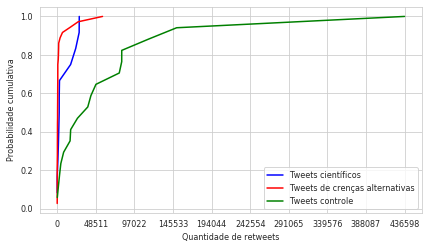

In [41]:
_= plt.figure(figsize = (6,3.5))
_= plt.plot(ecdf_retweets_s.x, ecdf_retweets_s.y, label= "Tweets científicos", color="blue")
_= plt.plot(ecdf_retweets_b.x, ecdf_retweets_b.y, label= "Tweets de crenças alternativas", color="red")
_= plt.plot(ecdf_retweets_c.x, ecdf_retweets_c.y, label= "Tweets controle", color="green")
_= plt.legend()
_= plt.xlabel("Quantidade de retweets")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.yticks(fontsize=8)
_= plt.xticks(np.linspace(0, np.max(ecdf_retweets_c.x), 10), fontsize=8)
_= plt.tight_layout()
_= plt.savefig("dist_rts.pdf", bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')

In [44]:
size_forests_c = dist_forests(graphs_c)
ecdf_fc = ECDF(np.array(tuple(size_forests_c.values())))
size_forests_s = dist_forests(graphs_s)
ecdf_fs = ECDF(np.array(tuple(size_forests_s.values())))
size_forests_b = dist_forests(graphs_b)
ecdf_fb = ECDF(np.array(tuple(size_forests_b.values())))

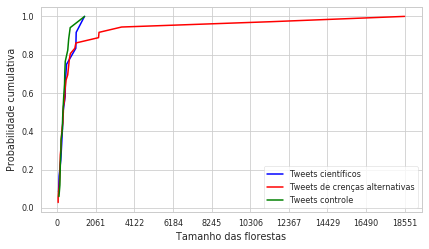

In [270]:
_= plt.figure(figsize = (6,3.5))
_= plt.plot(ecdf_fs.x, ecdf_fs.y, label= "Tweets científicos", color="blue")
_= plt.plot(ecdf_fb.x, ecdf_fb.y, label= "Tweets de crenças alternativas", color="red")
_= plt.plot(ecdf_fc.x, ecdf_fc.y, label= "Tweets controle", color="green")
_= plt.legend()
_= plt.xlabel("Tamanho das florestas")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.yticks(fontsize=8)
_= plt.xticks(np.linspace(0, np.max(ecdf_fb.x), 10), fontsize=8)
_= plt.tight_layout()
_= plt.savefig("dist_forests.pdf", bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')

In [42]:
def branching_factor(graphs):
    main_branch = dict()
    sec_branch = dict()
    for each in graphs:
        fa = each.split("_")
        branching_factor = dict()
        for item in graphs[each]:
            if(graphs[each].nodes[item]['replie_to'] is not None):
                try:
                    branching_factor[graphs[each].nodes[item]['replie_to']] = branching_factor[graphs[each].nodes[item]['replie_to']] + 1
                except:
                    branching_factor[graphs[each].nodes[item]['replie_to']] = 1
        if(len(fa) == 2):
            try:
                main_branch[each] = max([i for i in branching_factor.values()]) 
            except:
                main_branch[each] = 0
        else:
            try:
                sec_branch[each] = max([i for i in branching_factor.values()]) 
            except:
                sec_branch[each] = 0
    return main_branch, sec_branch

In [43]:
mbranch_c, sbranch_c = branching_factor(graphs_c)
mbranch_s, sbranch_s = branching_factor(graphs_s)
mbranch_b, sbranch_b = branching_factor(graphs_b)
ecdf_mbranch_c = ECDF(np.array(tuple(mbranch_c.values())))
ecdf_sbranch_c = ECDF(np.array(tuple(sbranch_c.values())))
ecdf_mbranch_s = ECDF(np.array(tuple(mbranch_s.values())))
ecdf_sbranch_s = ECDF(np.array(tuple(sbranch_s.values())))
ecdf_mbranch_b = ECDF(np.array(tuple(mbranch_b.values())))
ecdf_sbranch_b = ECDF(np.array(tuple(sbranch_b.values())))

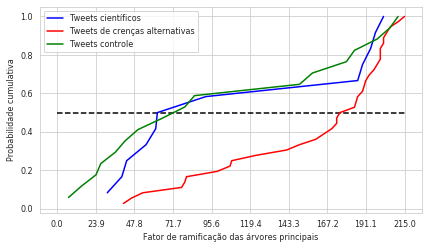

In [49]:
_= plt.figure(figsize = (6,3.5))
_= plt.plot([0, np.max(ecdf_mbranch_b.x)], [0.5, 0.5], color = "black", linestyle = "dashed")
_= plt.plot(ecdf_mbranch_s.x, ecdf_mbranch_s.y, label= "Tweets científicos", color="blue", alpha = 1)
_= plt.plot(ecdf_mbranch_b.x, ecdf_mbranch_b.y, label= "Tweets de crenças alternativas", color="red", alpha = 1.0)
_= plt.plot(ecdf_mbranch_c.x, ecdf_mbranch_c.y, label= "Tweets controle", color="green", alpha = 1)
_= plt.legend()
_= plt.xlabel("Fator de ramificação das árvores principais")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.yticks(fontsize=8)
_= plt.xticks(np.linspace(0, np.max(ecdf_mbranch_b.x), 10), fontsize=8)
_= plt.tight_layout()
_= plt.savefig("dist_main_branch.pdf", bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')

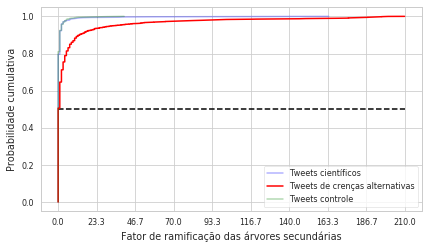

In [286]:
_= plt.figure(figsize = (6,3.5))
_= plt.plot([0, np.max(ecdf_sbranch_b.x)], [0.5, 0.5], color = "black", linestyle = "dashed")
_= plt.plot(ecdf_sbranch_s.x, ecdf_sbranch_s.y, label= "Tweets científicos", color="blue", alpha = 0.3)
_= plt.plot(ecdf_sbranch_b.x, ecdf_sbranch_b.y, label= "Tweets de crenças alternativas", color="red", alpha = 1)
_= plt.plot(ecdf_sbranch_c.x, ecdf_sbranch_c.y, label= "Tweets controle", color="green", alpha = 0.3)
_= plt.legend()
_= plt.xlabel("Fator de ramificação das árvores secundárias")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.yticks(fontsize=8)
_= plt.xticks(np.linspace(0, np.max(ecdf_sbranch_b.x), 10), fontsize=8)
_= plt.tight_layout()
_= plt.savefig("dist_forests.pdf", bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')
_= plt.savefig("dist_sec_branch_b.png", dpi = 900, orientation='portrait')

In [51]:
def response_time(graphs):
    arr = []
    for each in graphs:
        for item in graphs[each]:
            arr.append(graphs[each].nodes[item]['response_time'])     
    return np.array(arr)

In [52]:
ecdf_responses_c = ECDF(response_time(graphs_c))
ecdf_responses_s = ECDF(response_time(graphs_s))
ecdf_responses_b = ECDF(response_time(graphs_b))

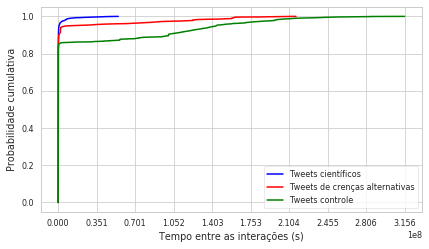

In [274]:
_= plt.figure(figsize = (6, 3.5))
_= plt.plot(ecdf_responses_s.x, ecdf_responses_s.y, label= "Tweets científicos", color="blue")
_= plt.plot(ecdf_responses_b.x, ecdf_responses_b.y, label= "Tweets de crenças alternativas", color="red")
_= plt.plot(ecdf_responses_c.x, ecdf_responses_c.y, label= "Tweets controle", color="green")
_= plt.legend()
_= plt.xlabel("Tempo entre as interações (s)")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.yticks(fontsize=8)
_= plt.xticks(np.linspace(0, np.max(ecdf_responses_c.x), 10), fontsize=8)
_= plt.tight_layout()
_= plt.savefig("dist_response.pdf", bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')

In [45]:
def users(graphs):
    main_users = dict()
    sec_users = dict()
    for each in graphs:
        fa = each.split("_")
        different_users = dict()
        for item in graphs[each]:
            try:
                different_users[graphs[each].nodes[item]['user_id']] += 1
            except:
                different_users[graphs[each].nodes[item]['user_id']] = 1
            if(len(fa) == 2):
                main_users[each] = len(different_users)
            else:
                sec_users[each] = len(different_users)    
    return main_users, sec_users

In [46]:
musers_c, susers_c = users(graphs_c)
musers_s, susers_s = users(graphs_s)
musers_b, susers_b = users(graphs_b)

In [47]:
ecdf_musers_c = ECDF(np.array(tuple(musers_c.values())))
ecdf_musers_s = ECDF(np.array(tuple(musers_s.values())))
ecdf_musers_b = ECDF(np.array(tuple(musers_b.values())))
ecdf_susers_c = ECDF(np.array(tuple(susers_c.values())))
ecdf_susers_s = ECDF(np.array(tuple(susers_s.values())))
ecdf_susers_b = ECDF(np.array(tuple(susers_b.values())))

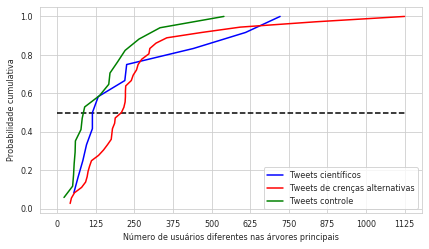

In [50]:
_= plt.figure(figsize = (6,3.5))
_= plt.plot([0, np.max(ecdf_musers_b.x)], [0.5, 0.5], color = "black", linestyle = "dashed")
_= plt.plot(ecdf_musers_s.x, ecdf_musers_s.y, label= "Tweets científicos", color="blue", alpha = 1)
_= plt.plot(ecdf_musers_b.x, ecdf_musers_b.y, label= "Tweets de crenças alternativas", color="red", alpha = 1)
_= plt.plot(ecdf_musers_c.x, ecdf_musers_c.y, label= "Tweets controle", color="green", alpha = 1)
_= plt.legend()
_= plt.xlabel("Número de usuários diferentes nas árvores principais")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.yticks(fontsize=8)
_= plt.xticks(np.linspace(0, np.max(ecdf_musers_b.x), 10), fontsize=8)
_= plt.tight_layout()
_= plt.savefig("dist_main_users.pdf", bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')

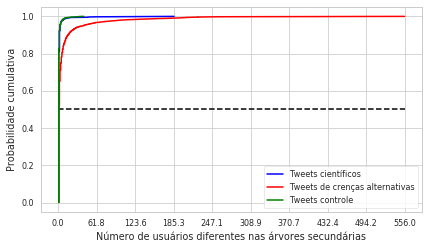

In [290]:
_= plt.figure(figsize = (6,3.5))
_= plt.plot([0, np.max(ecdf_susers_b.x)], [0.5, 0.5], color = "black", linestyle = "dashed")
_= plt.plot(ecdf_susers_s.x, ecdf_susers_s.y, label= "Tweets científicos", color="blue", alpha = 1)
_= plt.plot(ecdf_susers_b.x, ecdf_susers_b.y, label= "Tweets de crenças alternativas", color="red", alpha = 1)
_= plt.plot(ecdf_susers_c.x, ecdf_susers_c.y, label= "Tweets controle", color="green", alpha = 1)
_= plt.legend()
_= plt.xlabel("Número de usuários diferentes nas árvores secundárias")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.yticks(fontsize=8)
_= plt.xticks(np.linspace(0, np.max(ecdf_susers_b.x), 10), fontsize=8)
_= plt.tight_layout()
_= plt.savefig("dist_sec_users.png", bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')

In [229]:
def gen_boxplot(distribution_vec, name_file, original, graphs):
    # Create a figure instance
    fig = plt.figure(1, figsize=(6, 3.5))

    # Create an axes instance
    ax = fig.add_subplot(111)

    #Limiar do tweet original
    item = original.split("_")
    item = item[1].split(".")
    item = item[0]
    X = np.linspace(1, len(distribution_vec), len(distribution_vec))
    Y = 0*X + graphs[original].nodes[item]['sentiment']
    plt.plot(X, Y, sns.xkcd_rgb["pale red"], lw=1, label = "Sentimento do tweet original")
    
    #Eixo 0
    Y0 = 0*X
    plt.plot(X, Y0, sns.xkcd_rgb["blue"], lw=1, label = "Eixo 0")
    
    # Create the boxplot
    flierprops = dict(marker='o', markersize=2, linestyle='none')
    bp = ax.boxplot(distribution_vec, flierprops=flierprops,)
    
    _= plt.xlabel("Árvores de citação")
    _= plt.ylabel("Sentimento dos tweets")
    _= plt.legend()
    
    # Save the figure
    _= plt.yticks(fontsize=8)
    _= plt.xticks(fontsize=0)
    _= plt.tight_layout()
    _= plt.savefig(name_file, bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')

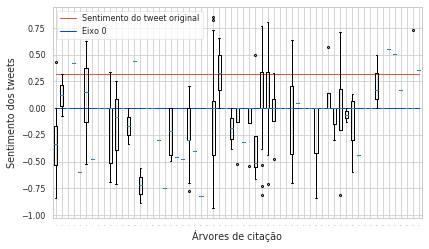

In [291]:
quotes = glob.glob("dados/beliefs/replies_238717783007977473_*.json")
original = "dados/beliefs/replies_238717783007977473.json"
all_sentiments, dist_sentiment, positives, negatives = get_dist_sentiment(quotes, graphs_b)
gen_boxplot(dist_sentiment.values(), "dist_sentiment_trump.png", original, graphs_b)

In [126]:
def frac_replies_greater_than(files, graphs, var):
    replies_positives = dict()
    replies_len = dict()
    for each in files:
        arq = each.split("_")
        original = arq[1].split(".")
        if len(arq) == 2:
            with open(each, 'r', encoding="utf8") as f: 
                data = json.load(f)
                replies_positives[each] = 0
                replies_len[each] = 0
                for tweet in data:
                    if var == 1 and data[tweet]['sentiment'] >= data[original[0]]['sentiment']:
                        replies_positives[each] += 1
                    elif var == 0 and data[tweet]['sentiment'] >= 0:
                        replies_positives[each] += 1
                    replies_len[each] += 1

    frac_sentiments = np.empty((0,1))
    for item in replies_positives:
        frac_sentiments = np.append(frac_sentiments, replies_positives[item]/replies_len[item])
    return frac_sentiments

In [305]:
frac_sentiments_c = frac_replies_greater_than(celebs, graphs_c, 1)
frac_sentiments_s = frac_replies_greater_than(science, graphs_s, 1)
frac_sentiments_b = frac_replies_greater_than(beliefs, graphs_b, 1)

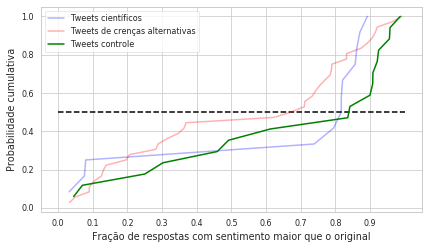

In [308]:
ecdf_c = ECDF(frac_sentiments_c)
ecdf_b = ECDF(frac_sentiments_b)    
ecdf_s = ECDF(frac_sentiments_s)

_= plt.figure(figsize = (6,3.5))
_= plt.plot([0, 1], [0.5, 0.5], color = "black", linestyle = "dashed")
_= plt.plot(ecdf_s.x, ecdf_s.y, label= "Tweets científicos", color="blue", alpha = 0.3)
_= plt.plot(ecdf_b.x, ecdf_b.y, label= "Tweets de crenças alternativas", color="red", alpha = 0.3)
_= plt.plot(ecdf_c.x, ecdf_c.y, label= "Tweets controle", color="green", alpha = 1)
_= plt.legend()
_= plt.xlabel("Fração de respostas com sentimento maior que o original")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.yticks(fontsize=8)
_= plt.xticks(np.arange(0, 1, 0.1), fontsize=8)
_= plt.tight_layout()
_= plt.savefig("dist_replies_c.png", bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')

In [309]:
frac_sentiments_c = frac_replies_greater_than(celebs, graphs_c, 0)
frac_sentiments_s = frac_replies_greater_than(science, graphs_s, 0)
frac_sentiments_b = frac_replies_greater_than(beliefs, graphs_b, 0)

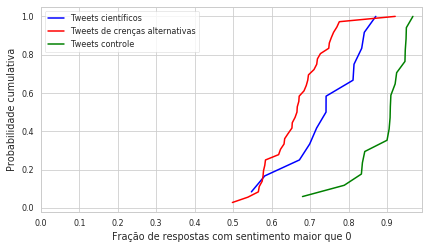

In [310]:
ecdf_c = ECDF(frac_sentiments_c)
ecdf_b = ECDF(frac_sentiments_b)    
ecdf_s = ECDF(frac_sentiments_s)

_= plt.figure(figsize = (6,3.5))
_= plt.plot(ecdf_s.x, ecdf_s.y, label= "Tweets científicos", color="blue")
_= plt.plot(ecdf_b.x, ecdf_b.y, label= "Tweets de crenças alternativas", color="red")
_= plt.plot(ecdf_c.x, ecdf_c.y, label= "Tweets controle", color="green")
_= plt.legend()
_= plt.xlabel("Fração de respostas com sentimento maior que 0")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.yticks(fontsize=8)
_= plt.xticks(np.arange(0, 1, 0.1), fontsize=8)
_= plt.tight_layout()
_= plt.savefig("dist_sentiment.pdf", bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')

In [32]:
def get_dist_sentiment(lista, graphs):
    dist_sentiment = dict()
    all_sentiments = list()
    for each in lista:
        aux = list()
        for item in graphs[each]:
            aux.append(graphs[each].nodes[item]['sentiment'])
            all_sentiments.append(graphs[each].nodes[item]['sentiment'])
        dist_sentiment[each] = np.array(aux)
    positives = dict()
    negatives = dict()
    for i in dist_sentiment:
        k = int(len(dist_sentiment[i])*0.5)
        if(k != 0):
            number = max(nlargest(k, dist_sentiment[i]))
        else:
            number = dist_sentiment[i][0]
        if(number >= 0):
            positives[i] = dist_sentiment[i]
        else:
            negatives[i] = dist_sentiment[i]
    return all_sentiments, dist_sentiment, positives, negatives

In [134]:
def classify_dist_quotes(dist_sentiment, original, graphs, var):
    item = original.split("_")
    item = item[1].split(".")
    item = item[0]

    maiores = dict()
    menores = dict()
    for each in dist_sentiment:
        maiores[each] = 0
        for num in dist_sentiment[each]:
            if var == 1 and num > graphs[original].nodes[item]['sentiment']:
                maiores[each] += 1
            elif var == 0 and num > 0: 
                maiores[each] += 1
    arvores_maiores = 0          

    for each in maiores:
        maiores[each] = maiores[each]/len(dist_sentiment[each])
        if(maiores[each] >= 0.5): #se pelo menos metade da árvore for mais positiva que o original
            arvores_maiores += 1

    arvores_maiores = arvores_maiores/len(maiores)
    return arvores_maiores
    

In [135]:
def frac_quotes_greater_than(files, graphs, var):
    frac = np.empty((0,1))
    for each in files:
        arq = each.split("_")
        if len(arq) == 2:
            original = each
            arq = each.split(".")
            quotes = glob.glob(arq[0] + "_*.json")
            all_sentiments, dist_sentiment, positives, negatives = get_dist_sentiment(quotes, graphs)
            classif = classify_dist_quotes(dist_sentiment, original, graphs, var)
            frac = np.append(frac, classif)
    return frac

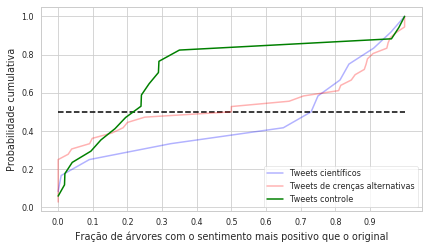

In [313]:
frac_c = frac_quotes_greater_than(celebs, graphs_c, 1)
ecdf_c = ECDF(frac_c)
frac_s = frac_quotes_greater_than(science, graphs_s, 1)
ecdf_s = ECDF(frac_s)
frac_b = frac_quotes_greater_than(beliefs,graphs_b, 1)
ecdf_b = ECDF(frac_b)
_= plt.figure(figsize = (6,3.5))
_= plt.plot([0, 1], [0.5, 0.5], color = "black", linestyle = "dashed")
_= plt.plot(ecdf_s.x, ecdf_s.y, label= "Tweets científicos", color = "blue", alpha = 0.3)
_= plt.plot(ecdf_b.x, ecdf_b.y, label= "Tweets de crenças alternativas", color = "red", alpha = 0.3)
_= plt.plot(ecdf_c.x, ecdf_c.y, label= "Tweets controle", color = "green", alpha = 1)
_= plt.legend()
_= plt.xlabel("Fração de árvores com o sentimento mais positivo que o original")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.yticks(fontsize=8)
_= plt.xticks(np.arange(0, 1, 0.1), fontsize=8)
_= plt.tight_layout()
_= plt.savefig("dist_quotes_c.png", bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')

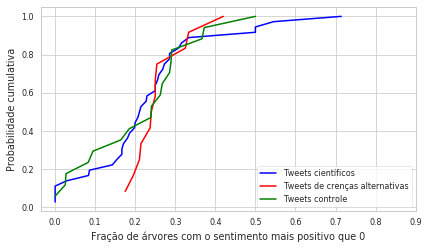

In [268]:
frac_c = frac_quotes_greater_than(celebs,graphs_c, 0)
ecdf_c = ECDF(frac_c)
frac_s = frac_quotes_greater_than(science,graphs_s, 0)
ecdf_s = ECDF(frac_s)
frac_b = frac_quotes_greater_than(beliefs,graphs_b, 0)
ecdf_b = ECDF(frac_b)

_= plt.figure(figsize = (6,3.5))
_= plt.plot(ecdf_s.x, ecdf_s.y, label= "Tweets científicos", color = "blue")
_= plt.plot(ecdf_b.x, ecdf_b.y, label= "Tweets de crenças alternativas", color = "red")
_= plt.plot(ecdf_c.x, ecdf_c.y, label= "Tweets controle", color = "green")
_= plt.legend()
_= plt.xlabel("Fração de árvores com o sentimento mais positivo que 0")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.yticks(fontsize=8)
_= plt.xticks(np.arange(0, 1, 0.1), fontsize=8)
_= plt.tight_layout()
_= plt.savefig("dist_sentiment.pdf", bbox_inches='tight', pad_inches=0.01, dpi = 800, orientation='portrait')